## Image Classification of Album Cover Images

In [1]:
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchmetrics.classification import BinaryF1Score
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

!pip install -q torch-lr-finder
from torch_lr_finder import LRFinder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataloaders and Datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomPosterize(4, p = 0.25),
    transforms.ColorJitter(brightness = (0.15, 0.90)),
    transforms.RandomRotation(degrees = 15),
    transforms.ToTensor()
])

In [3]:
TRAIN_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/train"
TEST_MERGED_PATH = "/kaggle/input/mumu-image-classification-album/mumu-images-classification/test"

In [4]:
train_dataset = datasets.ImageFolder(TRAIN_MERGED_PATH, transform = transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = datasets.ImageFolder(TEST_MERGED_PATH, transform = transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [5]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [6]:
train_dataset.classes

['ai', 'human']

## Model

In [7]:
models.list_models(module=models)

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [8]:
class CreativeNet(nn.Module):
    def __init__(self, train_baseline_classifier = False, num_output_classes = 2, dropout_rate = 0.20):
        super().__init__()
        
        # Set instance variables
        self.train_baseline_classifier = train_baseline_classifier
        self.num_outuput_classes = num_output_classes
        self.dropout_rate = dropout_rate
        
        # Set the current device for tensor calculations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Baseline: MobileNet V3 small
        self.baseline = models.convnext_tiny(weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        
        # Freeze the parameters of the base model (including but not limited to the last layers)
        for param in self.baseline.parameters():
            param.requires_grad = False
        
        if self.train_baseline_classifier:
            for param in self.baseline.classifier.parameters():
                param.requires_grad = True
                
        # Fully-connected block
        self.fc1 = nn.Linear(1000, 128)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(128, 32)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc3 = nn.Linear(32, self.num_outuput_classes)
        
    def forward(self, x):
        # Baseline
        x = x.to(self.device)
        x = self.baseline(x)
        
        # FC Block
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x))
        x = torch.sigmoid(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

MODEL_ARGS = {
    "train_baseline_classifier" : False, 
    "num_output_classes" : len(train_dataset.classes),
    "dropout_rate" : 0.35
}

model = CreativeNet(**MODEL_ARGS).to(device)

Using device cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 273MB/s] 


## Criterion and Optimiser

In [10]:
criterion = nn.CrossEntropyLoss()

  0%|          | 0/300 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.71E-02


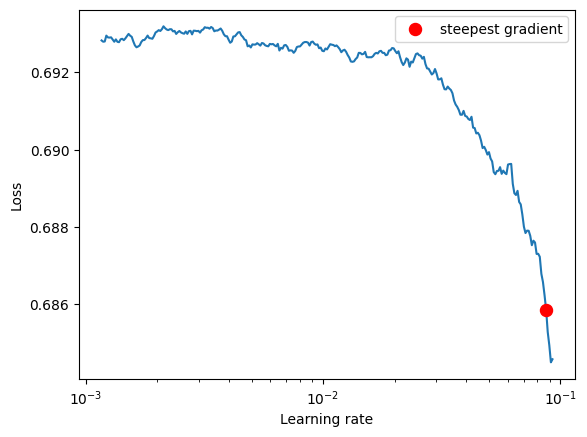

In [11]:
optimiser = optim.SGD(model.parameters(), lr = 0.001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=0.1, num_iter=300)

lr_finder.plot()
lr_finder.reset()

In [13]:
optimiser = optim.SGD(model.parameters(), lr = 8.71E-02)

## Metrics

In [14]:
metric = BinaryF1Score().to(device)

## Train and test the model

In [15]:
def train_test_loop(model, train_dataloader, test_dataloader, num_epochs = 100, save_prefix = "mumu_", verbose = False):
    # Save F1 scores and best model
    all_train_f1_scores = []
    all_test_f1_scores = []
    best_model = None
    candidate_f1_score = 0.0
    save_path = "fallback.pt"
    
    for epoch in tqdm(range(num_epochs)):
        # Training loop
        f1_scores = []
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            # Load the inputs
            inputs, labels = data
            inputs = torch.Tensor(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
                        
            # Forward + Backward + Optimise
            optimiser.zero_grad()
            outputs = model(inputs)
            outputs = torch.Tensor(outputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            
            # Training metrics calculation
            output_classes = torch.argmax(outputs, dim = 1)
            output_classes = torch.Tensor(output_classes).to(device)
            f1_score = metric(output_classes, labels)
            f1_scores.append(f1_score)
            
        # Update best scores and best model
        average_f1_score = (sum(f1_scores)/len(f1_scores))
        all_train_f1_scores.append(average_f1_score)
        if average_f1_score > candidate_f1_score:
            candidate_f1_score = average_f1_score
            average_f1_score_print = float(average_f1_score.cpu().detach())
            save_path = f"{save_prefix}_train_{str(average_f1_score_print).replace('.','_')}.pt"
            
        # Testing loop
        test_f1_scores = []
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                # Load the inputs
                inputs, labels = data
                inputs = torch.Tensor(inputs).to(device)
                labels = torch.Tensor(labels).to(device)

                # Forward
                outputs = model(inputs)
                outputs = torch.Tensor(outputs).to(device)
                output_classes = torch.argmax(outputs, dim = 1)
                output_classes = torch.Tensor(output_classes).to(device)
                
                # Testing metrics calculation
                f1_score = metric(output_classes, labels)
                test_f1_scores.append(f1_score)
            average_test_f1_score = (sum(test_f1_scores)/len(test_f1_scores))
            all_test_f1_scores.append(average_test_f1_score)
            
        
        # Verbose output if warranted
        if verbose:
            current_train_f1_score = all_train_f1_scores[-1]
            current_test_f1_score = all_test_f1_scores[-1]
            print(f"Train F1: {current_train_f1_score}, Test F1: {current_test_f1_score}")
        
    # Save best model at the end of the training loop
    torch.save(model.state_dict(), save_path)

In [16]:
TRAIN_ARGS = {
    "model" : model,
    "train_dataloader" : train_dataloader,
    "test_dataloader" : test_dataloader,
    "num_epochs" : 50,
    "save_prefix" : "mumu_convnext_tiny",
    "verbose" : True
}

In [17]:
train_test_loop(**TRAIN_ARGS)

  2%|▏         | 1/50 [00:05<04:09,  5.09s/it]

Train F1: 0.3444348871707916, Test F1: 0.13877201080322266


  4%|▍         | 2/50 [00:10<04:01,  5.04s/it]

Train F1: 0.3378068804740906, Test F1: 0.14883622527122498


  6%|▌         | 3/50 [00:15<03:55,  5.01s/it]

Train F1: 0.30695414543151855, Test F1: 0.1537766456604004


  8%|▊         | 4/50 [00:20<03:50,  5.00s/it]

Train F1: 0.2871883809566498, Test F1: 0.2018064558506012


 10%|█         | 5/50 [00:25<03:44,  5.00s/it]

Train F1: 0.28200462460517883, Test F1: 0.18865445256233215


 12%|█▏        | 6/50 [00:30<03:42,  5.06s/it]

Train F1: 0.24200549721717834, Test F1: 0.27396857738494873


 14%|█▍        | 7/50 [00:35<03:37,  5.06s/it]

Train F1: 0.30283480882644653, Test F1: 0.28975287079811096


 16%|█▌        | 8/50 [00:40<03:32,  5.06s/it]

Train F1: 0.36415451765060425, Test F1: 0.39827775955200195


 18%|█▊        | 9/50 [00:45<03:26,  5.04s/it]

Train F1: 0.40410155057907104, Test F1: 0.5019426345825195


 20%|██        | 10/50 [00:50<03:20,  5.02s/it]

Train F1: 0.45153895020484924, Test F1: 0.6804369688034058


 22%|██▏       | 11/50 [00:55<03:15,  5.01s/it]

Train F1: 0.5588517785072327, Test F1: 0.7633444666862488


 24%|██▍       | 12/50 [01:00<03:11,  5.04s/it]

Train F1: 0.6819339990615845, Test F1: 0.7803756594657898


 26%|██▌       | 13/50 [01:05<03:05,  5.02s/it]

Train F1: 0.7318312525749207, Test F1: 0.7906448841094971


 28%|██▊       | 14/50 [01:10<03:00,  5.00s/it]

Train F1: 0.7174313068389893, Test F1: 0.8014218807220459


 30%|███       | 15/50 [01:15<02:54,  4.99s/it]

Train F1: 0.7385100722312927, Test F1: 0.7950516939163208


 32%|███▏      | 16/50 [01:20<02:49,  4.99s/it]

Train F1: 0.7369714379310608, Test F1: 0.7625641822814941


 34%|███▍      | 17/50 [01:25<02:45,  5.00s/it]

Train F1: 0.7695839405059814, Test F1: 0.8046970367431641


 36%|███▌      | 18/50 [01:30<02:41,  5.05s/it]

Train F1: 0.7863609790802002, Test F1: 0.8176548480987549


 38%|███▊      | 19/50 [01:35<02:36,  5.06s/it]

Train F1: 0.7828826904296875, Test F1: 0.8232196569442749


 40%|████      | 20/50 [01:40<02:31,  5.05s/it]

Train F1: 0.7703203558921814, Test F1: 0.828826904296875


 42%|████▏     | 21/50 [01:45<02:25,  5.03s/it]

Train F1: 0.7539986371994019, Test F1: 0.8315473794937134


 44%|████▍     | 22/50 [01:50<02:21,  5.04s/it]

Train F1: 0.8256341218948364, Test F1: 0.815787672996521


 46%|████▌     | 23/50 [01:55<02:15,  5.02s/it]

Train F1: 0.826190710067749, Test F1: 0.833139181137085


 48%|████▊     | 24/50 [02:00<02:10,  5.02s/it]

Train F1: 0.8147094249725342, Test F1: 0.8253210783004761


 50%|█████     | 25/50 [02:05<02:05,  5.01s/it]

Train F1: 0.8320342302322388, Test F1: 0.8377501368522644


 52%|█████▏    | 26/50 [02:10<02:00,  5.02s/it]

Train F1: 0.826583743095398, Test F1: 0.8208784461021423


 54%|█████▍    | 27/50 [02:15<01:55,  5.01s/it]

Train F1: 0.825459361076355, Test F1: 0.80433189868927


 56%|█████▌    | 28/50 [02:20<01:50,  5.02s/it]

Train F1: 0.8380072712898254, Test F1: 0.8558472394943237


 58%|█████▊    | 29/50 [02:25<01:45,  5.03s/it]

Train F1: 0.8438120484352112, Test F1: 0.8557276725769043


 60%|██████    | 30/50 [02:30<01:40,  5.03s/it]

Train F1: 0.8589848279953003, Test F1: 0.8618800044059753


 62%|██████▏   | 31/50 [02:36<01:37,  5.11s/it]

Train F1: 0.8487939834594727, Test F1: 0.8597433567047119


 64%|██████▍   | 32/50 [02:41<01:31,  5.06s/it]

Train F1: 0.8545653223991394, Test F1: 0.8330634832382202


 66%|██████▌   | 33/50 [02:46<01:25,  5.04s/it]

Train F1: 0.8529761433601379, Test F1: 0.8267857432365417


 68%|██████▊   | 34/50 [02:50<01:20,  5.01s/it]

Train F1: 0.8713128566741943, Test F1: 0.8417676687240601


 70%|███████   | 35/50 [02:55<01:14,  5.00s/it]

Train F1: 0.8853167295455933, Test F1: 0.8438658714294434


 72%|███████▏  | 36/50 [03:00<01:09,  5.00s/it]

Train F1: 0.8811406493186951, Test F1: 0.8059474229812622


 74%|███████▍  | 37/50 [03:06<01:05,  5.03s/it]

Train F1: 0.857479453086853, Test F1: 0.8446338176727295


 76%|███████▌  | 38/50 [03:10<00:59,  4.99s/it]

Train F1: 0.8645462989807129, Test F1: 0.8185321688652039


 78%|███████▊  | 39/50 [03:15<00:55,  5.01s/it]

Train F1: 0.8744773268699646, Test F1: 0.8510031700134277


 80%|████████  | 40/50 [03:21<00:50,  5.02s/it]

Train F1: 0.8958252668380737, Test F1: 0.8313777446746826


 82%|████████▏ | 41/50 [03:26<00:45,  5.05s/it]

Train F1: 0.8870237469673157, Test F1: 0.8150593638420105


 84%|████████▍ | 42/50 [03:31<00:40,  5.08s/it]

Train F1: 0.873160719871521, Test F1: 0.8344539999961853


 86%|████████▌ | 43/50 [03:36<00:35,  5.10s/it]

Train F1: 0.8904693722724915, Test F1: 0.8243541717529297


 88%|████████▊ | 44/50 [03:41<00:30,  5.07s/it]

Train F1: 0.8795152306556702, Test F1: 0.8397969603538513


 90%|█████████ | 45/50 [03:46<00:25,  5.06s/it]

Train F1: 0.8973519206047058, Test F1: 0.8448693752288818


 92%|█████████▏| 46/50 [03:51<00:20,  5.05s/it]

Train F1: 0.9016876220703125, Test F1: 0.8452121019363403


 94%|█████████▍| 47/50 [03:56<00:15,  5.02s/it]

Train F1: 0.8931968808174133, Test F1: 0.8561636805534363


 96%|█████████▌| 48/50 [04:01<00:09,  4.99s/it]

Train F1: 0.8980733752250671, Test F1: 0.8117918372154236


 98%|█████████▊| 49/50 [04:06<00:05,  5.01s/it]

Train F1: 0.894988477230072, Test F1: 0.8459264039993286


100%|██████████| 50/50 [04:11<00:00,  5.03s/it]

Train F1: 0.8961926698684692, Test F1: 0.8426166772842407
